# Exporting American Movie Box Office Hits 

### Regresssion Model Stepwise Analysis <a id='top'></a> 

1. [Research Question](#1)<br/>
2. [Scraped: Movie Adaptations Data](#2) <br/>
3. [Exporatory Data Analysis: Movie Adaptations Dataframe](#3)<br/>
   [3a. Explore features correlation](#3a)<br/>
   [3b. Explore and handle categorical data](#3b)<br/>
4. [Cross-Validation](#4)<br/>
5. [Modeling](#5)<br/>
6. [Model Tuning](#6) <br/>
   [6a. Regularization](#6a)<br/>
   [6b. Features engineering](#6b)<br/>
   [6c. Linear regression assumptions](#6c)<br/>
7. [Best Model ](#7)<br/>
8. [Results](#8)<br/>
   [8a. Interpretability](#8a)<br/>
   [8b. Predictions](#8b)<br/>

In [1]:
import pandas as pd
import numpy as np
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab as py
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats



In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline


## 1. Research Question<a id='1'></a> 

* RQ. Can a model predict a movie adaptaion <sup>1</sup> international total gross revenue based on movie data available on boxofficemojo.com?
* Data source: boxofficemojo.com 
* Error metric: mean_squared_error

<sup>1</sup> Adapted from books, television shows, events, video games, or plays. 


## 2. Scraped [Movie Adaptations Data](https://github.com/slp22/regression-project/blob/main/adaptation_movies_webscraping.ipynb) 


## 3. Exporatory Data Analysis: [Movie Adaptations Dataframe](https://github.com/slp22/regression-project/blob/main/adaptation_movies_eda.ipynb) 

In [3]:
movie_df = pd.read_csv('clean_df.csv')
movie_df.drop(columns=['link_stub'], inplace=True)
movie_df.head(1)

,international_total_gross,domestic_total_gross,rank,movie_title,max_theaters,opening_theathers,worldwide_total_gross,domestic_opening,budget,release_date,runtime,distributor,genres,rating
0,1119261396,543638043,6,The Lion King,4802.0,4725.0,1662899439,191770759,260000000,20190711,118.0,Walt Disney Studios Motion Pictures,Adventure Animation Drama Family Musical,PG


In [ ]:
movie_df.describe()

In [ ]:
# check for null values
movie_df.isnull().sum()

In [4]:
# drop null values
movie_df.dropna(axis=0, how='any', inplace=True)

In [ ]:
# double check for null values
movie_df.isnull().sum()

In [ ]:
movie_df.info()

### 3a. Explore features correlation<a id='3a'></a> 

In [ ]:
# sns.pairplot(movie_df, height=5, aspect=1.5);

In [ ]:
# heatmap correlation matrix
sns.heatmap(movie_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

### Correlation Summary

#### Target-Features
*target = `international_total_gross`*
* target correlated with (highest to lowest):
    * `domestic_total_gross`
    * `domestic_opening`
    * `budget`
    * `max_theaters`
    * `opening_theathers`

Target is highly correlated with `worldwide_total_gross`; has known multicollinearity as:<br/>
`worldwide_total_gross` = `domestic_total_gross` + `international_total_gross`

####  Features-Features: Positive Correlation
* domestic_total_gross:
    * `domestic_opening`
    * `worldwide_total_gross`
    * `budget`
    * `max_theaters`
    * `opening_theathers`
* domestic_opening:<br/>
    * `budget`
    * `max_theaters`
    * `opening_theathers`
* max_theaters:
    * `opening_theathers`
    * `budget`
    * `domestic_opening`

####  Features-Features: Negative Correlation
* rank:
    * `domestic_total_gross`
    * `max_theaters`
    * `opening_theathers`
    * `domestic_opening`
    * `budget`
    


### 3b. Explore and handle categorical data<a id='3b'></a> 

In [ ]:
# explore genres as candidate for dummies
print('Unique genres:', movie_df.genres.nunique())
print('\n')
print('Genres counts\n', movie_df['genres'].value_counts())
# 👎 too many; look for other dummy variables. 

In [5]:
# explore MPAA rating as candidate for dummies
print('Unique MPAA ratings:', movie_df.rating.nunique())
print('\n')
rating_count = movie_df['rating'].value_counts()
print('Rating counts\n', rating_count)
# 👍 easy-to-use for dummy variables

Unique MPAA ratings: 4


Rating counts
 PG13    304
R       217
PG      189
G         8
Name: rating, dtype: int64


In [6]:
# get dummies for MPAA rating 
df_dummies_rating = pd.get_dummies(movie_df, columns=['rating'], drop_first=True)
df_dummies_rating.head(2)
movie_df = df_dummies_rating
movie_df.head(1)

,international_total_gross,domestic_total_gross,rank,movie_title,max_theaters,opening_theathers,worldwide_total_gross,domestic_opening,budget,release_date,runtime,distributor,genres,rating_PG,rating_PG13,rating_R
0,1119261396,543638043,6,The Lion King,4802.0,4725.0,1662899439,191770759,260000000,20190711,118.0,Walt Disney Studios Motion Pictures,Adventure Animation Drama Family Musical,1,0,0


In [7]:
# explore distributor as candidate for dummies 
print('Unique distributors:', movie_df.distributor.nunique())
print('\n')
distributor_count = movie_df['distributor'].value_counts()
print('Distributor count\n', distributor_count)
# 👍 Reasonable amount, group lower frequencies into an other category.

Unique distributors: 66


Distributor count
 Warner Bros.                           123
Twentieth Century Fox                   89
Paramount Pictures                      88
Walt Disney Studios Motion Pictures     73
Universal Pictures                      68
                                      ... 
Fox Atomic                               1
United Artists Releasing                 1
Pantelion Films                          1
TriStar Pictures                         1
Cinedigm Entertainment Group             1
Name: distributor, Length: 66, dtype: int64


In [8]:
# create distributor other category
distributor_other = list(distributor_count[distributor_count < 20].index)
movie_df['distributor'] = movie_df['distributor'].replace(distributor_other, 'other')

# get dummies for distributor
df_dummies_distributor = pd.get_dummies(movie_df, columns=['distributor'], drop_first=True)
movie_df = df_dummies_distributor
movie_df.head(1)

,international_total_gross,domestic_total_gross,rank,movie_title,max_theaters,opening_theathers,worldwide_total_gross,domestic_opening,budget,release_date,...,rating_PG,rating_PG13,rating_R,distributor_Paramount Pictures,distributor_Sony Pictures Entertainment (SPE),distributor_Twentieth Century Fox,distributor_Universal Pictures,distributor_Walt Disney Studios Motion Pictures,distributor_Warner Bros.,distributor_other
0,1119261396,543638043,6,The Lion King,4802.0,4725.0,1662899439,191770759,260000000,20190711,...,1,0,0,0,0,0,0,1,0,0


In [9]:
movie_df.columns

Index(['international_total_gross', 'domestic_total_gross', 'rank',
       'movie_title', 'max_theaters', 'opening_theathers',
       'worldwide_total_gross', 'domestic_opening', 'budget', 'release_date',
       'runtime', 'genres', 'rating_PG', 'rating_PG13', 'rating_R',
       'distributor_Paramount Pictures',
       'distributor_Sony Pictures Entertainment (SPE)',
       'distributor_Twentieth Century Fox', 'distributor_Universal Pictures',
       'distributor_Walt Disney Studios Motion Pictures',
       'distributor_Warner Bros.', 'distributor_other'],
      dtype='object')

[back to top](#top)

## 4. Cross-Validation<a id='4'></a> 

In [10]:
# separate target from select features
y = movie_df['international_total_gross']
X = movie_df.loc[:,['domestic_total_gross', 
                    'domestic_opening', 
                    'budget',
                    'max_theaters', 
                    'opening_theathers',
                    'rank',
                    'runtime',
                    'release_date',
#                     'movie_title', 
                    'rating_PG', 
                    'rating_PG13',
                    'rating_R',
                    'distributor_Paramount Pictures',
                    'distributor_Sony Pictures Entertainment (SPE)',
                    'distributor_Twentieth Century Fox', 
                    'distributor_Universal Pictures',
                    'distributor_Walt Disney Studios Motion Pictures',
                    'distributor_Warner Bros.', 
                    'distributor_other']]

In [11]:
# split test data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.info()

In [12]:
## set up k-folds 
kfold = KFold(n_splits=5, shuffle=True, random_state = 42)

[back to top](#top)

## 5. Modeling<a id='5'></a> 

In [13]:
# simple linear regression
lin_reg = LinearRegression()

scores = cross_val_score(lin_reg, X_train, y_train, cv=kfold)
print('k-fold indivdual scores:', scores)
print("linear regression mean score: ", np.mean(scores))

lin_reg.fit(X_train, y_train)

k-fold indivdual scores: [0.7486569  0.757162   0.86214297 0.72927468 0.74714238]
linear regression mean score:  0.7688757853732312


LinearRegression()

In [ ]:
# train: fitted vs. actual
y_train_predict = lin_reg.predict(X_train)

plt.scatter(y_train, y_train_predict, alpha=0.2)
plt.plot([0, 400], [0, 400])
plt.title("y_train_predict vs. y_train");

In [ ]:
# test: fitted vs. actual
y_test_predict = lin_reg.predict(X_test)

plt.scatter(y_test, y_test_predict)
plt.plot([0, 400], [0, 400])
plt.title("y_test_pred vs. y_test");

In [ ]:
# residuals vs. predicted
lin_reg_residuals = y_train - y_train_predict

plt.scatter(y_train_predict, lin_reg_residuals)
plt.plot([0,400], [0, 0])
plt.title("Residuals vs. Predicted")

## 6. Model Tuning<a id='6'></a> 

In [14]:
# standard-scaling features before regularization 
std = StandardScaler()
std.fit(X_train.values)

# apply scaler to train data
X_train_std = std.transform(X_train)

# apply scaler to test data
X_test_std = std.transform(X_test)

/Users/sandraparedes/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/sandraparedes/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


### 6a. Regularization<a id='6a'></a> 

In [ ]:
# alpha parameter number range
# a_range = 10**np.linspace(-2,2,200)

In [15]:
# lasso model
lasso_model = Lasso(alpha = 1000)
lasso_model.fit(X_train_std, y_train)

Lasso(alpha=1000)

In [ ]:
list(zip(X_train.columns, lasso_model.coef_))

In [16]:
# ridge model 
ridge_model = Ridge(alpha = 1000)
ridge_model.fit(X_train_std, y_train)

Ridge(alpha=1000)

In [ ]:
list(zip(X_train.columns, ridge_model.coef_))

In [17]:
# elastic model 
elastic_model = ElasticNet(alpha = 1000, l1_ratio=1)
elastic_model.fit(X_train_std, y_train)

ElasticNet(alpha=1000, l1_ratio=1)

In [ ]:
list(zip(X_train.columns, elastic_model.coef_))

In [18]:
y_pred = lin_reg.predict(X_test)
print("Linear Regression:", mean_squared_error(y_test, y_pred))

y_pred = lasso_model.predict(X_test)
print("Lasso Regression:", mean_squared_error(y_test, y_pred))

y_pred = ridge_model.predict(X_test)
print("Ridge Regression:", mean_squared_error(y_test, y_pred))

y_pred = elastic_model.predict(X_test)
print("ElasticNet Regression:", mean_squared_error(y_test, y_pred))

Linear Regression: 5288170065095361.0
Lasso Regression: 3.015688882486208e+32
Ridge Regression: 3.0502321010351254e+31
ElasticNet Regression: 3.015688882486208e+32


/Users/sandraparedes/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
/Users/sandraparedes/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/sandraparedes/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


[back to top](#top)

### 6b. Features engineering<a id='6b'></a> 

In [19]:
# log transformation for monetary columns 

# check for zeros in columns before log transformation 
count = (movie_df['international_total_gross'] == 0).sum()
print('count zeros in international_total_gross:', count)

count = (movie_df['domestic_total_gross'] == 0).sum()
print('count of zeros in domestic_total_gross:', count)

count = (movie_df['budget'] == 0).sum()
print('count of zeros in budget:', count)
# budget: min $0, max $270,000,000
# 👎 zeros throwing division-zero error; will not transform 

count = (movie_df['domestic_opening'] == 0).sum()
print('count of zeros in domestic_opening:', count)
# domestic_opening: min $0, max $191,770,800
# 👎 zeros throwing division-zero error; will not transform 


# 👍 international_total_gross and domestic_total_gross
# international_total_gross: min $98, max $1,119,261,000
movie_df['log_international_total_gross'] = np.log(movie_df['international_total_gross'])

# domestic_total_gross: min $742, max $543,638,043
movie_df['log_domestic_total_gross'] = np.log(movie_df['domestic_total_gross'])


count zeros in international_total_gross: 0
count of zeros in domestic_total_gross: 0
count of zeros in budget: 214
count of zeros in domestic_opening: 1


In [20]:
# profit = domestic_total_gross - budget
movie_df['profit'] = (movie_df['domestic_total_gross'] - movie_df['budget'])

In [21]:
# opening = domestic_opening * opening_theathers
movie_df['opening'] = (movie_df['domestic_opening'] * movie_df['opening_theathers'])

In [22]:
# opening_minus_budget = domestic_opening * budget
movie_df['opening_minus_budget'] = (movie_df['domestic_opening'] - movie_df['budget'])

In [26]:
movie_df.columns

Index(['international_total_gross', 'domestic_total_gross', 'rank',
       'movie_title', 'max_theaters', 'opening_theathers',
       'worldwide_total_gross', 'domestic_opening', 'budget', 'release_date',
       'runtime', 'genres', 'rating_PG', 'rating_PG13', 'rating_R',
       'distributor_Paramount Pictures',
       'distributor_Sony Pictures Entertainment (SPE)',
       'distributor_Twentieth Century Fox', 'distributor_Universal Pictures',
       'distributor_Walt Disney Studios Motion Pictures',
       'distributor_Warner Bros.', 'distributor_other',
       'log_international_total_gross', 'log_domestic_total_gross', 'profit',
       'opening', 'opening_minus_budget'],
      dtype='object')

In [42]:
# separate target from select features
y2 = movie_df['international_total_gross']
X2 = movie_df.loc[:,['domestic_total_gross', 
                       'rank', 
                       'max_theaters', 
                       'opening_theathers',
                       'domestic_opening', 
                       'budget', 
                       'release_date',
                       'runtime', 
                       'rating_PG', 
                       'rating_PG13', 
                       'rating_R',
                       'distributor_Paramount Pictures',
                       'distributor_Sony Pictures Entertainment (SPE)',
                       'distributor_Twentieth Century Fox', 
                       'distributor_Universal Pictures',
                       'distributor_Walt Disney Studios Motion Pictures',
                       'distributor_Warner Bros.', 
                       'distributor_other',
                       'log_international_total_gross', 
                       'log_domestic_total_gross', 
                       'profit',
                       'opening', 
                       'opening_minus_budget']]


In [43]:
# split test data set
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, 
                                                                  test_size=0.2, 
                                                                  random_state=42)


In [44]:
# standard-scaling features before regularization 
std = StandardScaler()
std.fit(X2_train.values)

# apply scaler to train data
X2_train_std = std.transform(X2_train)

# apply scaler to test data
X2_test_std = std.transform(X2_test)

/Users/sandraparedes/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/sandraparedes/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [48]:
# lasso model + feature engineering
lasso_model_feat = Lasso(alpha = 1000000)
lasso_model_feat.fit(X2_train_std, y_train)

Lasso(alpha=1000000)

In [49]:
list(zip(X_ft_train.columns, lasso_model_feat.coef_))

[('domestic_total_gross', 110750241.52231793),
 ('rank', 27606416.490036495),
 ('max_theaters', -1822211.0495561764),
 ('opening_theathers', -4053435.878393262),
 ('domestic_opening', 0.0),
 ('budget', 0.0),
 ('release_date', 7131871.889962489),
 ('runtime', 6505003.834725986),
 ('rating_PG', 2588692.808026557),
 ('rating_PG13', -0.0),
 ('rating_R', -0.0),
 ('distributor_Paramount Pictures', -933949.0562269454),
 ('distributor_Sony Pictures Entertainment (SPE)', -0.0),
 ('distributor_Twentieth Century Fox', 1042971.9519426785),
 ('distributor_Universal Pictures', -857623.6724335651),
 ('distributor_Walt Disney Studios Motion Pictures', 1149865.4008911166),
 ('distributor_Warner Bros.', 879372.905241442),
 ('distributor_other', 0.0),
 ('log_international_total_gross', 42622480.93355351),
 ('log_domestic_total_gross', -9877509.076026358),
 ('profit', 0.0),
 ('opening', 33181702.37109326),
 ('opening_minus_budget', -12217565.369718239)]

In [50]:
y2_pred = lasso_model_feat.predict(X2_test)
print("Lasso Regression:", mean_squared_error(y2_test, y2_pred))

# feature engineering improved score from 3.015688882486208e+32

Lasso Regression: 2.6144073251892585e+37


/Users/sandraparedes/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


[back to top](#top)

### 6c. Linear regression assumptions<a id='6c'></a> 

Assumption 1: Regression is linear in parameters and correctly specified

In [52]:
# plot regression fit, residual plot, and normal q-q plot

def diagnostic_plot(X2, y2):
    plt.figure(figsize=(20,5))
    
    lin_reg = LinearRegression()
    lin_reg.fit(X2, y2)
    predict = lin_reg.predict(X2)

    plt.subplot(1, 3, 1)
    plt.scatter(X2,y2)
    plt.plot(X2, predict, color='blue',linewidth=1)
    plt.title("Regression Fit")
    plt.xlabel("X")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    residual = y2 - predict
    plt.scatter(predict, residual)
    plt.title("Residual Plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    stats.probplot(residual, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    

ValueError: x and y must be the same size

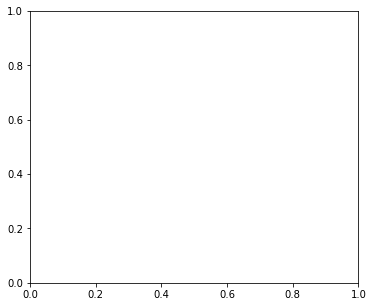

In [53]:
diagnostic_plot(X2, y2)

Assumption 2: Residuals should be normally distributed with zero mean

In [ ]:
# residuals vs. predicted
residuals = y_train - y_train_predict
plt.scatter(y_train_predict, residuals)
plt.plot([0,400], [0, 0])
plt.title("Residuals vs. Predicted");


In [ ]:
# inspect histogram
movie_df.international_total_gross.hist(bins=10)
plt.title('Histogram of Dependent Variable (international_total_gross)');

In [ ]:
# inspect residual normality in qqplot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()


Assumption 3: Error terms must have constant variance

In [ ]:
# histogram
movie_df.international_total_gross.hist();

In [ ]:
# test: fitted vs. actual
y_train_predict = lasso_model.predict(X_test)


In [ ]:
# reg plot

plt.scatter(movie_df.domestic_total_gross, y)
plt.scatter(movie_df.domestic_total_gross, y_train_predict);

Assumption 4: Errors are uncorrelated across observations

In [ ]:
# plot residuals over time

movie_df['date_time'] = pd.to_datetime(movie_df.release_date, format="%Y-%m-%d")
movie_df.head(3)

a4 = movie_df[['date_time','residuals']].set_index('date_time')
a4.plot(style=".");

# there seems to be no pattern, so we're good!

Assumption 5: No independent variable is a perfect linear function of other independent variable 


In [ ]:
# Removed worldwide_total_gross because of known multicollinearity:
# `worldwide_total_gross` = `domestic_total_gross` + `international_total_gross`


[back to top](#top)

## 7. Best Model<a id='7'></a> 
Fit best model on (train + val), score on test!

In [ ]:
# pd.DataFrame(list(zip(range(10), lasso_model.best_estimator_.coef_)))

[back to top](#top)

## 8. Results<a id='8'></a> 

### 8a. Interpretability<a id='8a'></a> 

In [ ]:
# Coefficients, what are the top predictors

### 8b. Predictions<a id='8b'></a> 

In [ ]:
# Make a prediction for a new value, does it make sense?

In [ ]:
# linear regression plot
f, ax = plt.subplots(figsize=(12, 8))
sns.regplot(x='domestic_total_gross', y='international_total_gross', data=movie_df);


Slides, article, and code available at: https://github.com/slp22/regression-project

[back top top](#top)